In [1]:
import matplotlib.pyplot as plt
import hail as hl

In [2]:
hl.init()

Running on Apache Spark version 2.2.0
SparkUI available at http://10.1.7.107:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version devel-3b89d834fa8f
NOTE: This is a beta version. Interfaces may change
  during the beta period. We recommend pulling
  the latest changes weekly.


In [3]:
ht = hl.Table.parallelize([
            {'a': '1', 'c': .5,'d': 'foo'},
            {'a': '1', 'c': .6,'d': 'foo'},
], hl.tstruct(a=hl.tstr,
                      c=hl.tfloat32, d=hl.tstr))
mt = ht.to_matrix_table(['a'], ['d'])

mt.entries().show()

2018-08-09 13:54:53 Hail: INFO: Coerced almost-sorted dataset


+-----+-----+-------------+
| a   | d   |           c |
+-----+-----+-------------+
| str | str |     float32 |
+-----+-----+-------------+
| 1   | foo | 5.00000e-01 |
+-----+-----+-------------+



In [15]:
colors = {'1' : "#08ad4d", '2' : "#cc0648", '3' : "#bbdd11", '4' : "#4a87d6", 
                '5' : "#6f50b7", '6' : "#e0c10f", '7' : "#d10456", '8' : "#2779d8", 
                '9' : "#9e0631", '10' : "#5fcc06", '11' : "#4915a8", '12' : "#0453d3", 
                '13' : "#7faf26", '14' : "#d17b0c", '15' : "#526d13", '16' : "#e82019", 
                '17' : "#125b07", '18' : "#12e2c3", '19' : "#914ae2", '20' : "#95ce10", 
                '21' : "#af1ca8", '22' : "#eaca3a", 'X' : "#1c8caf"}

In [16]:
keys = list(colors.keys())
c = list(colors.values())

In [6]:
x = [i for i in range(1,24)]

In [7]:
y = [0 for i in range(0,23)]

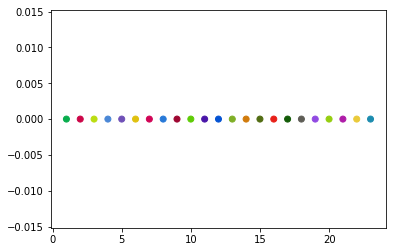

In [8]:
plt.scatter(x, y, c=c)
plt.show()

In [9]:
ds = hl.read_matrix_table('tutorial_data/1kg.mt')
table = (hl.import_table('tutorial_data/1kg_annotations.txt', impute=True)
         .key_by('Sample'))
ds = ds.annotate_cols(**table[ds.s])
gwas = hl.linear_regression(y=ds.CaffeineConsumption, x=ds.GT.n_alt_alleles(), covariates=[1.0])
pca_eigenvalues, pca_scores, _ = hl.hwe_normalized_pca(ds.GT)
cds = ds.annotate_cols(pca = pca_scores[ds.s])
linear_regression_results = hl.linear_regression(
    y=cds.CaffeineConsumption, x=cds.GT.n_alt_alleles(),
    covariates=[1.0, cds.isFemale, cds.pca.scores[0], cds.pca.scores[1], cds.pca.scores[2]])
caffeine_pval_tbl = (linear_regression_results
       .select_rows(linear_regression_results.linreg.p_value)
       .select_entries()
       .rows())
caffeine = caffeine_pval_tbl.annotate_globals(color_dict = colors)
caffeine = (caffeine
            .annotate(
                global_position = caffeine.locus.global_position(),
                neg_log_pval = -hl.log(caffeine.p_value),
                color = caffeine.color_dict[caffeine.locus.contig])
           .select('global_position','p_value','neg_log_pval', 'color')
           .rename({'p_value':'pval'}))

2018-08-09 13:55:53 Hail: INFO: Reading table to impute column types
2018-08-09 13:55:53 Hail: INFO: Finished type imputation
  Loading column 'Sample' as type 'str' (imputed)
  Loading column 'Population' as type 'str' (imputed)
  Loading column 'SuperPopulation' as type 'str' (imputed)
  Loading column 'isFemale' as type 'bool' (imputed)
  Loading column 'PurpleHair' as type 'bool' (imputed)
  Loading column 'CaffeineConsumption' as type 'float64' (imputed)
2018-08-09 13:55:54 Hail: INFO: Coerced sorted dataset
2018-08-09 13:55:56 Hail: INFO: linear_regression: running on 284 samples for 1 response variable y,
    with input variable x, and 1 additional covariate...
2018-08-09 13:56:01 Hail: INFO: hwe_normalized_pca: running PCA using 10452 variants.
2018-08-09 13:56:03 Hail: INFO: pca: running PCA with 10 components...
2018-08-09 13:56:15 Hail: INFO: linear_regression: running on 284 samples for 1 response variable y,
    with input variable x, and 5 additional covariates...


In [ ]:
#SKIP already written
ht_with_pheno = caffeine_pval_tbl.annotate(
    phenotype='caffeine_consumption')
print(ht_with_pheno.count())
mt = ht_with_pheno.distinct().to_matrix_table(['locus','alleles'],['phenotype'])
mt.count()
mt.describe()
mt.write('/Users/maccum/manhattan_data/raw/caffeine_mt', overwrite=True)

In [ ]:
caffeine.describe()

In [10]:
collected = caffeine.collect()

In [17]:
gp = []
nlp = []
color_list = []

In [18]:
for i in range(0, len(collected)):
    gp.append(collected[i].global_position)
    nlp.append(collected[i].neg_log_pval)
    color_list.append(colors[collected[i].locus.contig])

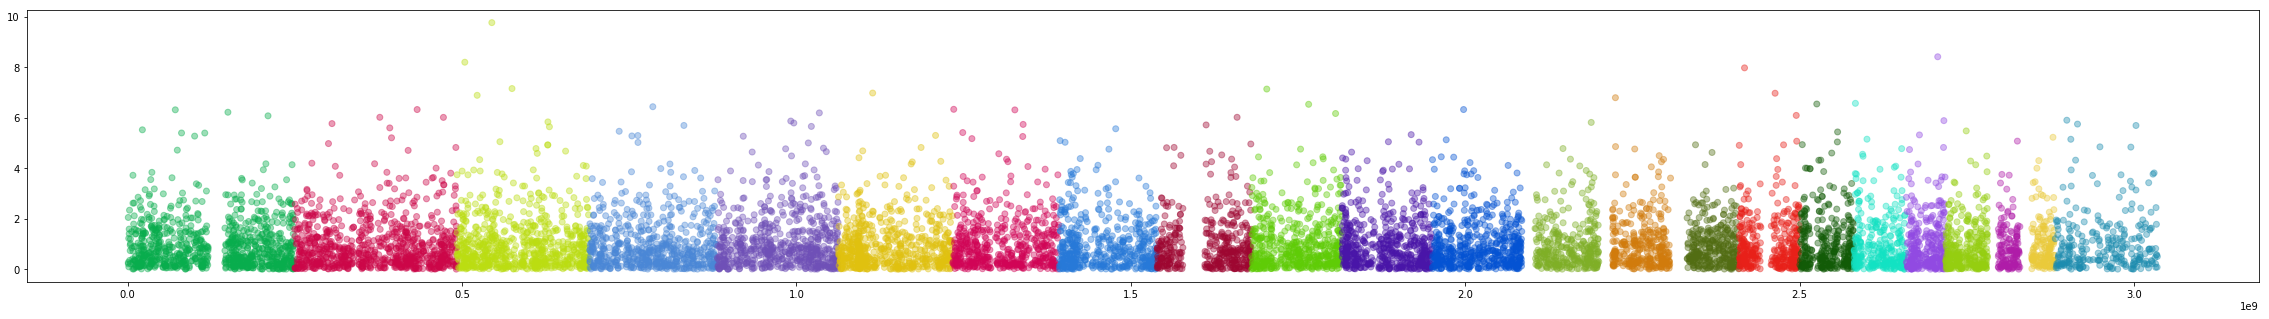

In [19]:
plt.figure(figsize=(40,5))
plt.scatter(gp, nlp, c=color_list, alpha=0.4)
plt.show()

In [14]:
caffeine.show()

+---------------+------------+-----------------+-------------+--------------+---------+
| locus         | alleles    | global_position |        pval | neg_log_pval | color   |
+---------------+------------+-----------------+-------------+--------------+---------+
| locus<GRCh37> | array<str> |           int64 |     float64 |      float64 | str     |
+---------------+------------+-----------------+-------------+--------------+---------+
| 1:904165      | ["G","A"]  |          904164 | 1.28903e-01 |  2.04870e+00 | #08ad4d |
| 1:909917      | ["G","A"]  |          909916 | 7.66467e-01 |  2.65963e-01 | #08ad4d |
| 1:986963      | ["C","T"]  |          986962 | 8.08964e-01 |  2.12001e-01 | #08ad4d |
| 1:1563691     | ["T","G"]  |         1563690 | 2.95368e-01 |  1.21953e+00 | #08ad4d |
| 1:1707740     | ["T","G"]  |         1707739 | 9.12548e-01 |  9.15151e-02 | #08ad4d |
| 1:2252970     | ["C","T"]  |         2252969 | 2.04427e-01 |  1.58754e+00 | #08ad4d |
| 1:2284195     | ["T","C"]  |  

In [28]:
# TILE GENERATION
mt = hl.read_matrix_table('/Users/maccum/manhattan_data/raw/caffeine_mt').rename({'p_value': 'pval'})
hl.TileGenerator.add_manhattan_data_to_mt(mt, colors).write(
    '/Users/maccum/manhattan_data/with_plot_fields/caffeine_mt', overwrite=True)


2018-08-09 13:58:49 Hail: INFO: adding manhattan data to mt
2018-08-09 13:58:49 Hail: INFO: done adding manhattan data to mt
2018-08-09 13:58:50 Hail: INFO: wrote 10879 items in 16 partitions to /Users/maccum/manhattan_data/with_plot_fields/caffeine_mt


In [29]:
tg = hl.TileGenerator(hl.read_matrix_table('/Users/maccum/manhattan_data/with_plot_fields/caffeine_mt'),
                  '/Users/maccum/manhattan_data/plots/caffeine_plots',
                  colors,
                      regen=True
                  )

2018-08-09 13:59:06 Hail: INFO: Coerced sorted dataset
2018-08-09 13:59:06 Hail: INFO: wrote 1 item in 1 partition


In [30]:
tg.generate_tile_layer(phenotype='caffeine_consumption',
                      zoom=2,
                      )

2018-08-09 13:59:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:11 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:15 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:17 Hail: INFO: Ordering unsorted dataset with network shuffle


Zoom level: 2 |██████████████████████████████████████████████████| 100.0% Complete


In [31]:
tg.generate_tile_layer(phenotype='caffeine_consumption',zoom=3)

2018-08-09 13:59:20 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:22 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:24 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:28 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:30 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:33 Hail: INFO: Ordering unsorted dataset with network shuffle


Zoom level: 3 |██████████████████████████████████████████████████| 100.0% Complete


In [32]:
tg.generate_tile_layer(phenotype='caffeine_consumption',zoom=4)


2018-08-09 13:59:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:36 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:39 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:40 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:42 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:43 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:44 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:47 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:48 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:52 Hail: INFO: Ordering unsorted dataset with network shuffle


Zoom level: 4 |██████████████████████████████████████████████████| 100.0% Complete


In [33]:
tg.generate_tile_layer(phenotype='caffeine_consumption',zoom=5)

2018-08-09 13:59:53 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:54 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:55 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:56 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:57 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:57 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:58 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 13:59:59 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:02 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:03 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:05 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:06 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:07 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:07 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:08 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:10 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:11 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:12 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:13 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:13 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:15 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:16 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:17 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:19 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:19 Hail: INFO: Ordering unsorted dataset with network shuffle


Zoom level: 5 |██████████████████████████████████████████████████| 100.0% Complete


In [34]:
tg.generate_tile_layer(phenotype='caffeine_consumption',zoom=6)

2018-08-09 14:00:20 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:21 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:22 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:22 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:23 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:24 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:24 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:25 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:27 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:28 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:29 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:29 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:30 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:31 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:31 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:33 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:34 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:36 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:39 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:40 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:42 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:43 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:44 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:44 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:45 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:47 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:48 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:49 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:52 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:53 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:53 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:54 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:55 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:55 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:56 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:57 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:58 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:58 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:00:59 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:01 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:02 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:03 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:03 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:05 Hail: INFO: Ordering unsorted dataset with network shuffle


Zoom level: 6 |██████████████████████████████████████████████████| 100.0% Complete


In [35]:
tg.generate_tile_layer(phenotype='caffeine_consumption',zoom=7)

2018-08-09 14:01:06 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:06 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:07 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:08 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:08 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:10 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:10 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:11 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:12 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:12 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:13 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:13 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:15 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:16 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:16 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:17 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:19 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:19 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:20 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:21 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:21 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:22 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:23 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:24 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:25 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:25 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:27 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:28 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:29 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:29 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:30 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:30 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:31 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:33 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:34 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:34 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:36 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:36 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:39 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:39 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:40 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:42 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:43 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:44 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:44 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:45 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:47 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:48 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:48 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:49 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:52 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:53 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:53 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:54 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:55 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:55 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:56 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:57 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:57 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:58 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:01:59 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:01 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:02 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:03 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:05 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:06 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:06 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:07 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:07 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:08 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:10 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:11 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:11 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:12 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:13 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:15 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:16 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:16 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:17 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:19 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:20 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:20 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:21 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:21 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:22 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:23 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:23 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:24 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:25 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:25 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:27 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:28 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:28 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:29 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:29 Hail: INFO: Ordering unsorted dataset with network shuffle


Zoom level: 7 |██████████████████████████████████████████████████| 100.0% Complete


In [36]:
tg.generate_tile_layer(phenotype='caffeine_consumption',zoom=8)

2018-08-09 14:02:30 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:31 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:31 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:33 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:34 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:34 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:36 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:39 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:40 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:40 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:42 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:43 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:43 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:44 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:45 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:45 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:47 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:47 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:48 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:49 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:49 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:52 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:52 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:53 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:54 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:54 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:55 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:55 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:56 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:57 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:58 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:58 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:59 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:02:59 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:01 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:02 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:02 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:03 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:05 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:06 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:06 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:07 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:08 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:08 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:10 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:11 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:12 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:12 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:13 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:13 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:15 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:16 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:16 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:17 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:17 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:19 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:20 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:20 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:21 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:21 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:22 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:23 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:23 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:24 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:24 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:25 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:27 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:27 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:28 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:28 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:29 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:29 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:30 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:30 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:31 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:31 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:33 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:33 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:34 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:34 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:36 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:39 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:40 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:40 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:42 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:42 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:43 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:43 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:44 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:44 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:45 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:45 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:47 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:47 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:48 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:49 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:49 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:52 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:52 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:53 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:53 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:54 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:54 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:55 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:56 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:56 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:57 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:58 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:58 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:03:59 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:00 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:01 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:01 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:02 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:02 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:03 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:03 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:04 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:05 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:05 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:06 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:06 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:07 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:08 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:08 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:09 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:10 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:10 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:11 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:12 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:12 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:13 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:14 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:15 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:16 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:17 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:17 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:18 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:19 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:19 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:20 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:21 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:21 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:22 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:22 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:23 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:24 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:24 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:25 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:25 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:26 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:27 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:27 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:28 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:28 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:29 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:30 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:30 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:31 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:31 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:32 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:33 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:34 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:34 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:35 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:36 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:37 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:38 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:39 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:40 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:40 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:41 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:42 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:43 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:43 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:44 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:45 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:45 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:46 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:47 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:47 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:48 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:49 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:49 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:50 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:51 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:52 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:52 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:53 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:54 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:54 Hail: INFO: Ordering unsorted dataset with network shuffle


2018-08-09 14:04:55 Hail: INFO: Ordering unsorted dataset with network shuffle


Zoom level: 8 |██████████████████████████████████████████████████| 100.0% Complete
